## Using Data Analytics to Manage a Solar Power Plant
<font size='+1'> 
In this analysis, we will be examining 34 days of power generation and sensor reading data from a solar power plant in India with the following goals:  
    
1.  Predict the power generation for the nex few days 
2.  Identify the need for panel cleaning/maintenance
3.  Identify faulty or suboptimal equipment performance

We will be using data analytics skills and python to perform this analysis with the following workflow: 

* Conducting Exploratoy Data Analysis (EDA) to gain insights into the data. This will involve :  
   * Describing the data
   * Visualizing the data
   * Exploring correlations between numerical features
* Performing feature engineering and data wrangling to prepare the data for modeling. 
    
Our goal is to demonstrate how data analysis tools can be used to gain a better understanding of the power generation patterns in a solar power plant and to identify ways to improve  performance. 


Data source:  [Solar Power Generration Data](https://www.kaggle.com/datasets/anikannal/solar-power-generation-data)


 </font>


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime
import matplotlib.dates as mdates 

<font size='+1'> 
Let's take a closer look at the content of the generation dataset:  </font>

In [2]:
custom_date_parser = lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M') 
gen=pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv',index_col='DATE_TIME', parse_dates=['DATE_TIME'], date_parser=custom_date_parser)

gen.head(5)

,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
DATE_TIME,,,,,,
2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [3]:
gen.info(), gen.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68778 entries, 2020-05-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PLANT_ID     68778 non-null  int64  
 1   SOURCE_KEY   68778 non-null  object 
 2   DC_POWER     68778 non-null  float64
 3   AC_POWER     68778 non-null  float64
 4   DAILY_YIELD  68778 non-null  float64
 5   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 3.7+ MB


(None,
 PLANT_ID       0
 SOURCE_KEY     0
 DC_POWER       0
 AC_POWER       0
 DAILY_YIELD    0
 TOTAL_YIELD    0
 dtype: int64)

In [4]:
gen.groupby('DATE_TIME').count().head(10)

,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
DATE_TIME,,,,,,
2020-05-15 00:00:00,21,21,21,21,21,21
2020-05-15 00:15:00,21,21,21,21,21,21
2020-05-15 00:30:00,21,21,21,21,21,21
2020-05-15 00:45:00,21,21,21,21,21,21
2020-05-15 01:00:00,22,22,22,22,22,22
2020-05-15 01:15:00,21,21,21,21,21,21
2020-05-15 01:30:00,21,21,21,21,21,21
2020-05-15 01:45:00,22,22,22,22,22,22
2020-05-15 02:00:00,21,21,21,21,21,21


<font size='+1'>  Upon examining the first few lines of the generation dataset, it appears that there are duplicates in the DATE_TIME column. By grouping the dataset by the DATE_TIME columns and counting the number of occurrences, it is evident that data has been recorded every 15 minutes for all 22 inverters. As there are only 21 points for most intervals, it is possible that one of the inverters may not functioning properly. In later parts of the analysis, this will be investigated further.   </font>

<font size='+1'> 
 Below, we examine the contents of the sensor reading dataset as well as explore possible correlations between its parameters.  </font>

In [5]:
custom_date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S') 
sen=pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv',index_col='DATE_TIME', parse_dates=['DATE_TIME'], date_parser=custom_date_parser)
sen.drop(['PLANT_ID','SOURCE_KEY'],axis=1, inplace=True)
sen.head()

,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,
2020-05-15 00:00:00,25.184316,22.857507,0.0
2020-05-15 00:15:00,25.084589,22.761668,0.0
2020-05-15 00:30:00,24.935753,22.592306,0.0
2020-05-15 00:45:00,24.846130,22.360852,0.0
2020-05-15 01:00:00,24.621525,22.165423,0.0


In [6]:
sen.info(), sen.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3182 entries, 2020-05-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AMBIENT_TEMPERATURE  3182 non-null   float64
 1   MODULE_TEMPERATURE   3182 non-null   float64
 2   IRRADIATION          3182 non-null   float64
dtypes: float64(3)
memory usage: 99.4 KB


(None,
 AMBIENT_TEMPERATURE    0
 MODULE_TEMPERATURE     0
 IRRADIATION            0
 dtype: int64)

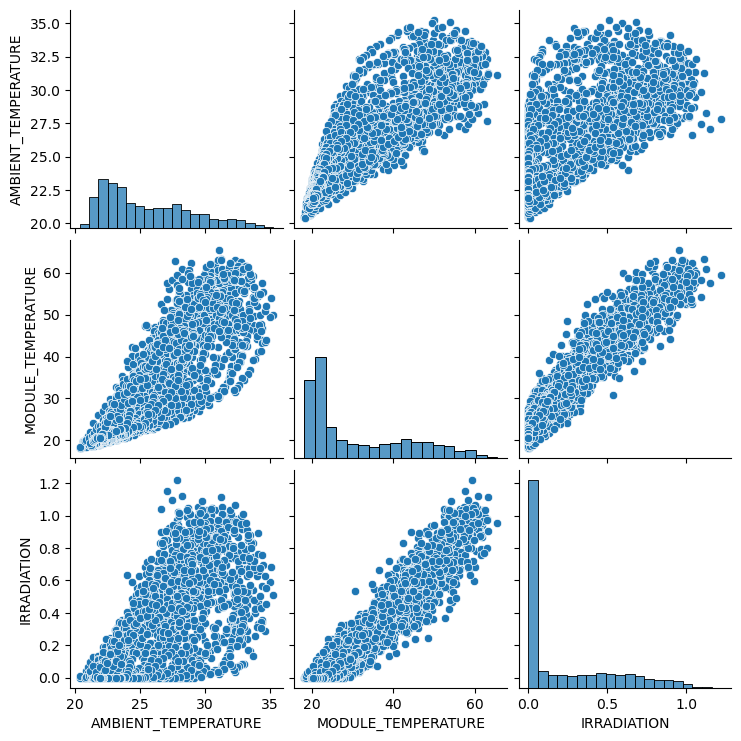

In [7]:
sns.pairplot(sen)

<AxesSubplot:>

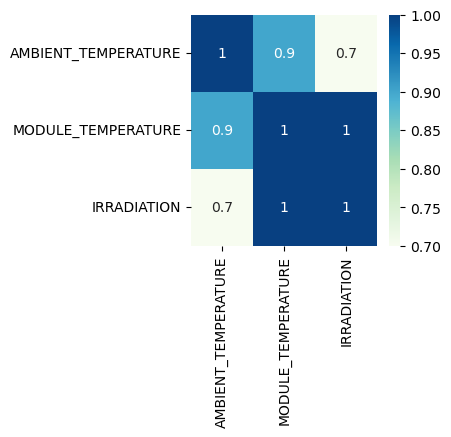

In [8]:
plt.figure(figsize=(3,3))
sns.heatmap(sen.corr().round(1),cmap='GnBu',annot=True)  #list of cmap options: https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f

<font size='+1'>
    
    The pairplots and correlation heatmap clearly demonstrate that:
        
        1. The correlation between module temperature and irradiation is stronger compared to that between ambient temperature and irradiation.
        2. The module temperature can reach significantly higher levels than ambient temperature, up to approximately twice as high 
</font>



<font size='+1'> 
Below are some visulizations that provide a better understanding of sensor reading and generation datasets:  </font>

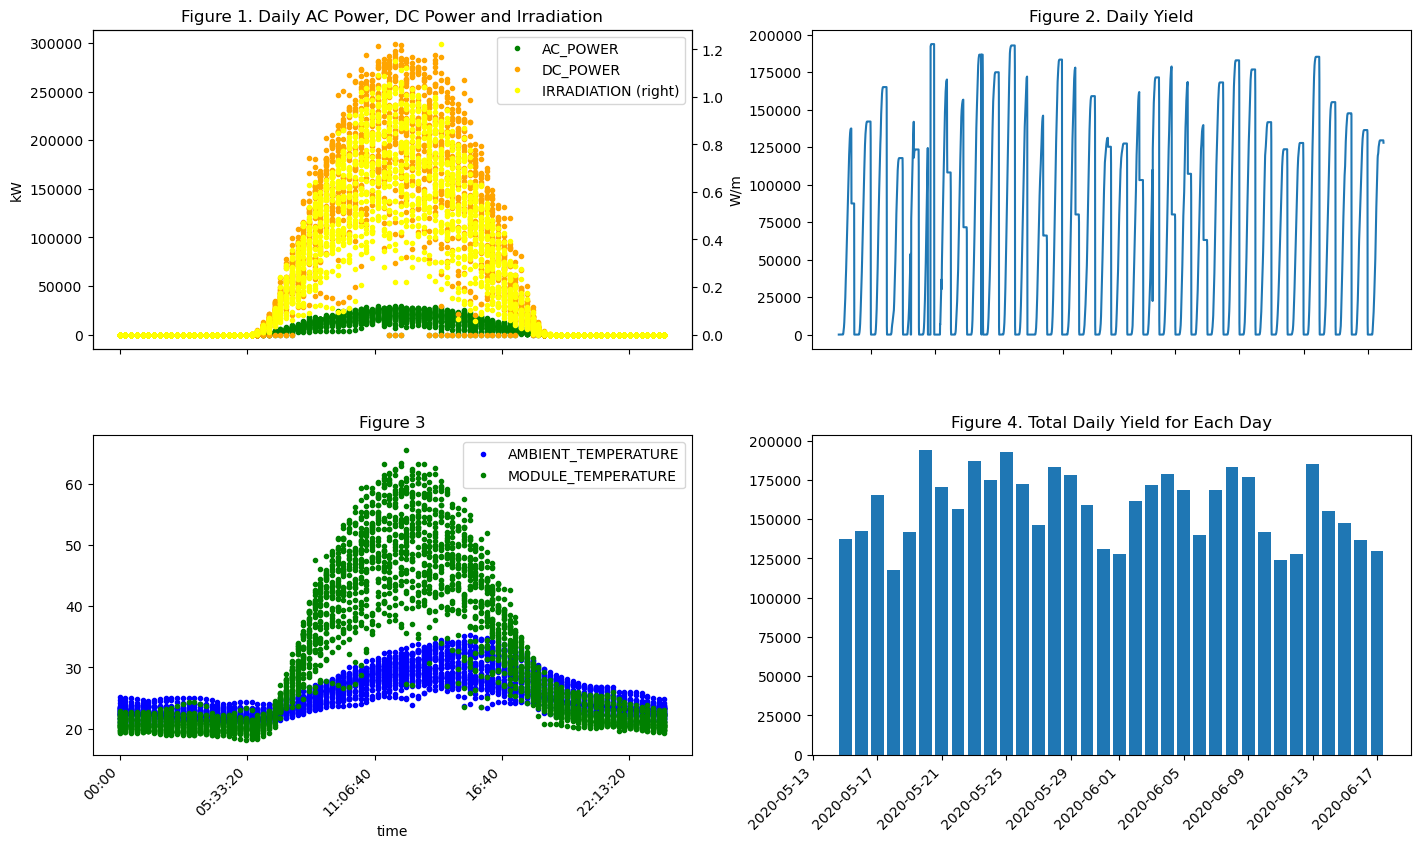

In [9]:
gen1= gen.resample('15min').sum() 
gen1['time']=gen1.index.time
sen['time']=sen.index.time

f,ax=plt.subplots(2,2, figsize=(15,10))
plt.tight_layout(pad=5)

gen1.plot(x='time',y='AC_POWER', style='.',color='green',ax=ax[0,0])
gen1.plot(x='time',y='DC_POWER', style='.',color='orange', ax=ax[0,0])
sen.plot(x='time',y='IRRADIATION', style='.',color='yellow', ax=ax[0,0],secondary_y=True)

ax[1,1].bar(x=gen1.index.date, height=gen1.DAILY_YIELD)
ax[0,1].plot(gen1.DAILY_YIELD)
sen.plot(x='time',y='AMBIENT_TEMPERATURE', style='.',color='blue', ax=ax[1,0])
sen.plot(x='time',y='MODULE_TEMPERATURE', style='.',color='green', ax=ax[1,0])

ax[0,0].set_title('Figure 1. Daily AC Power, DC Power and Irradiation')
ax[0,1].set_title('Figure 2. Daily Yield')
ax[1,0].set_title('Figure 3')
ax[1,1].set_title('Figure 4. Total Daily Yield for Each Day')

ax[0,0].set_ylabel('kW')
ax[0,0].right_ax.set_ylabel('W/m')
f.subplots_adjust(wspace=0.2)

f.autofmt_xdate(rotation=45)


Text(0.5, 1.0, 'Figure 5. Inverters AC Power Generation Druing the Day')

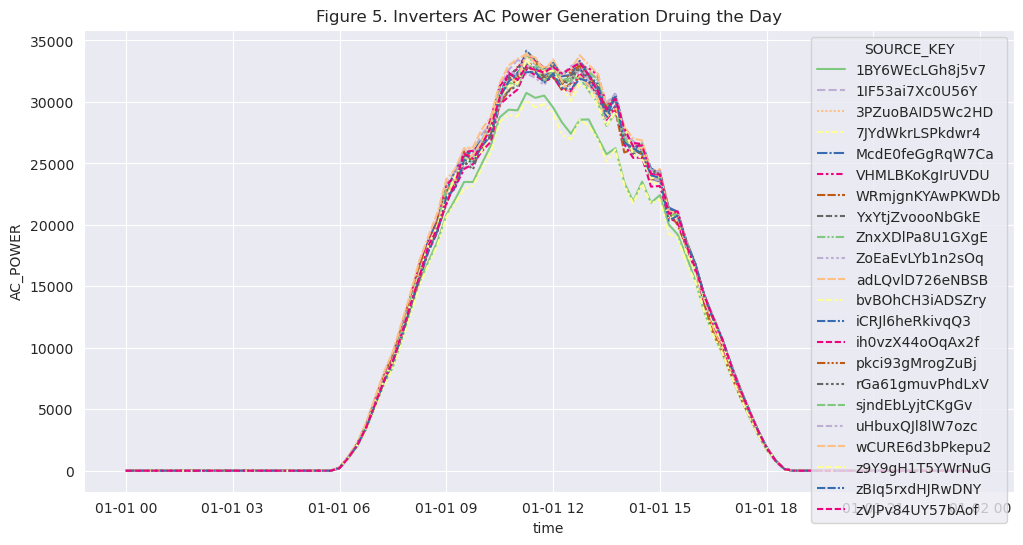

In [10]:
gen['time'] = pd.to_datetime(gen.index.time, format='%H:%M:%S')
plt.figure(figsize=(12,6))
sns.set_style("darkgrid")
sns.lineplot(gen.groupby(['time','SOURCE_KEY']).AC_POWER.sum().reset_index(),
             x='time',
             y='AC_POWER',
             hue='SOURCE_KEY',
             style='SOURCE_KEY',
             palette='Accent')
plt.title('Figure 5. Inverters AC Power Generation Druing the Day')

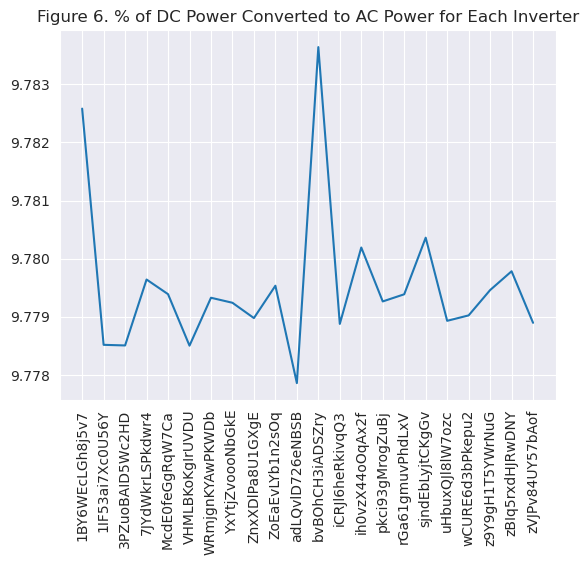

In [11]:
df=(gen.groupby('SOURCE_KEY').AC_POWER.sum()/gen.groupby('SOURCE_KEY').DC_POWER.sum())*100
plt.plot(df)
plt.xticks(df.index,rotation=90)
plt.title('Figure 6. % of DC Power Converted to AC Power for Each Inverter')
plt.show()


<font size='+1'> According to Figure 1 and 6, it appears that all inverters have an efficiency of around 10%, indicating that only about 10% of DC power is being converted to AC power. As mentioned earlier, there may be issues with some of the 22 inverters. Figure 6 shows that two inverters are underperforming however it cannot be the cause of the power plant's underperformance. 
In what follows we will merge sensor reading and generation datasets to investigate the impact of enviromental factors, such as temperature, on the performance of the power plant. </font>

In [12]:
gen.drop('time', axis=1, inplace=True)
sen.drop('time', axis=1, inplace=True)
gen_sen=gen.join(sen,how='left')
gen_sen.reset_index(inplace=True)

<AxesSubplot:>

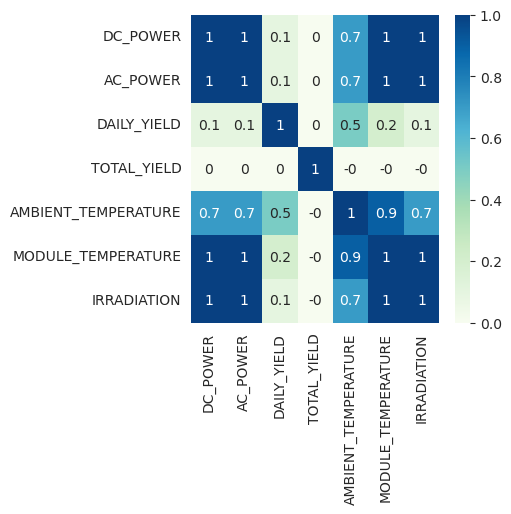

In [13]:
plt.figure(figsize=(4,4))
sns.heatmap(gen_sen.drop('PLANT_ID',axis=1).corr().round(1),cmap='GnBu',annot=True)

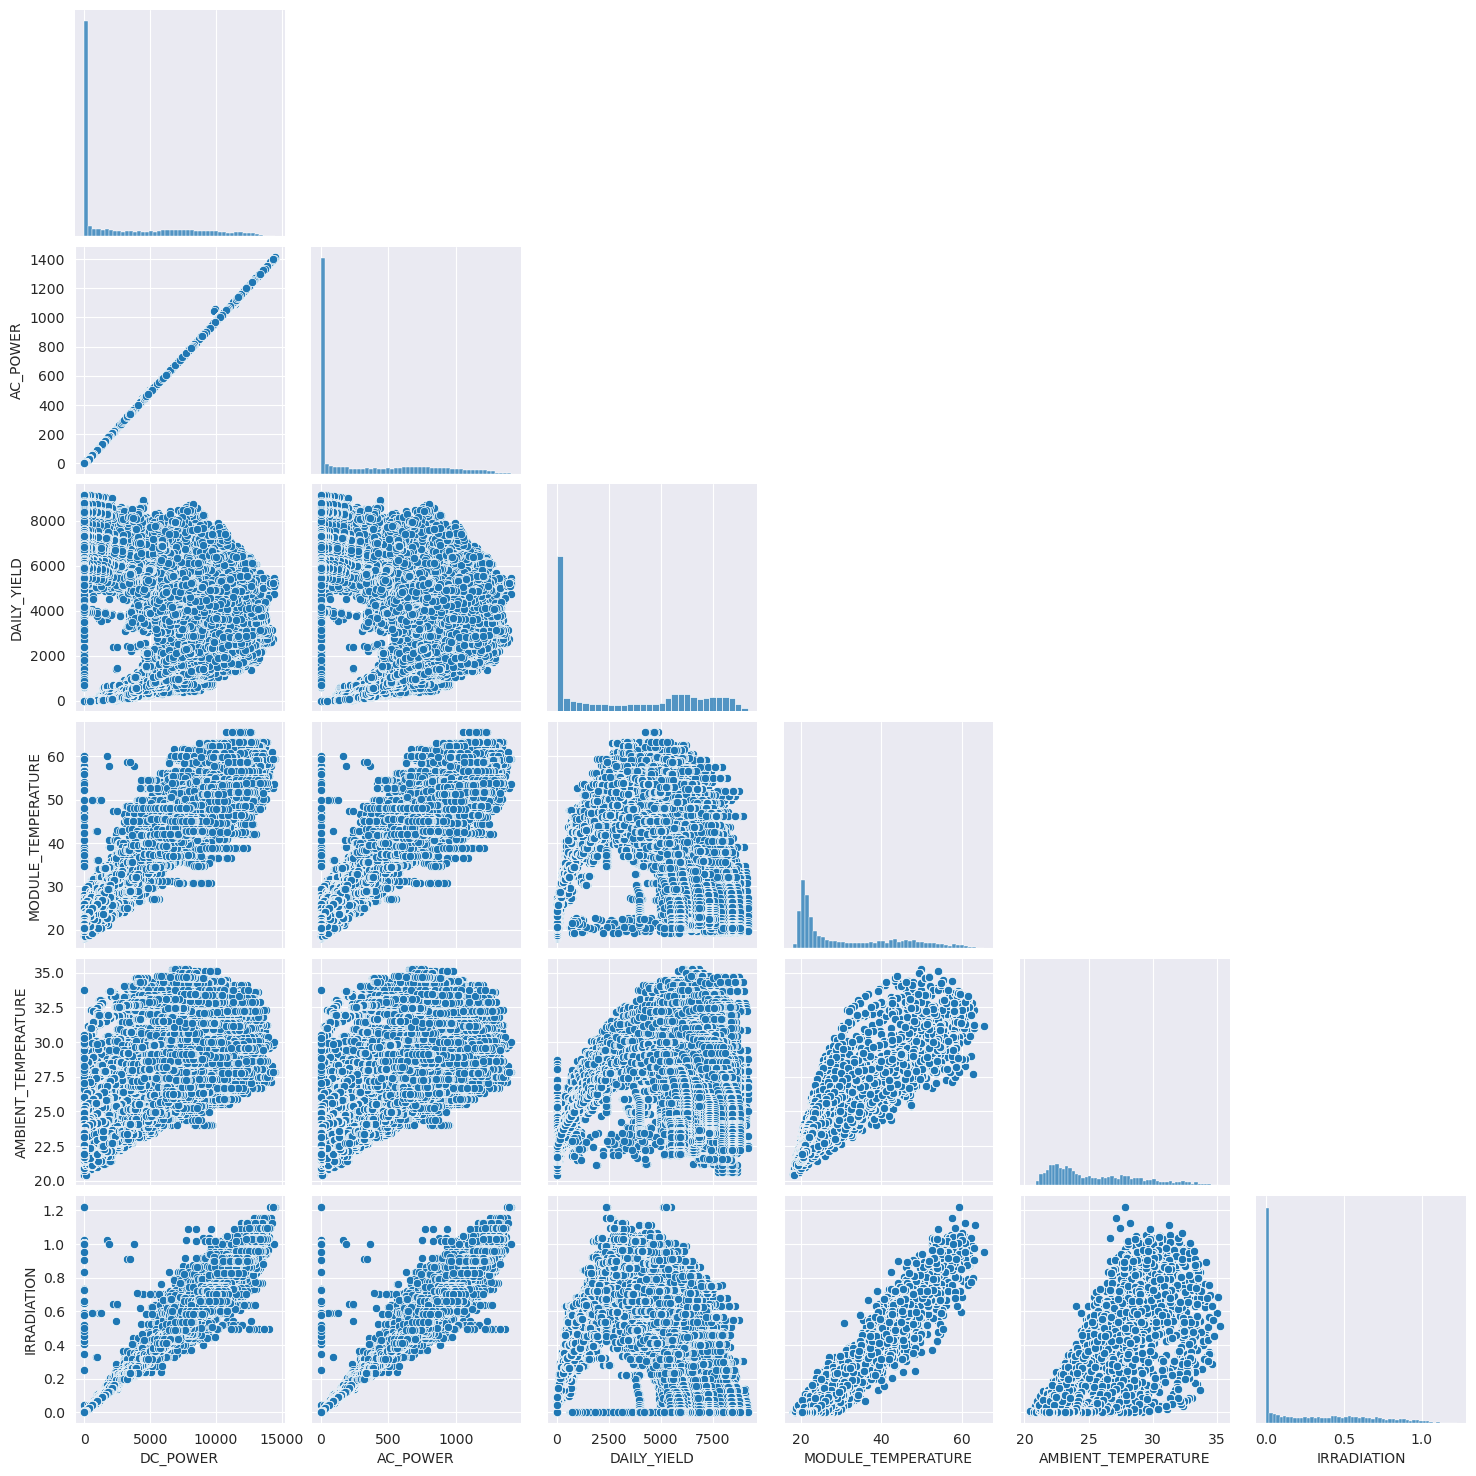

In [14]:
sns.pairplot(gen_sen[['DC_POWER', 'AC_POWER','DAILY_YIELD', 'MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE', 'IRRADIATION']], corner=True)

<font size='+1'> 
    
*     Module_Temperature is possitively correlated with both Irradiation and Ambient_Temperature, however the impact of ambient temperature on module temperature may not be as strong as irradiation due to other factors such as wind and shading.
*     Otlier incidents where irradiation is present but DC power is either zero or extremely low,could be an indication of failures at the solar panel level or even complete shutdown of the power plant.
*     AC power for all inverters is at only 10% of DC power, this could be indicative of a general malfunctioning of the inverters. One possible cause for this could be the age of the inverters, which may require maintenance or replacement to restore their proper functionality.    
    
</font>

In [15]:
gen_sen['time']= gen_sen.DATE_TIME.dt.hour
gen_sen['Day']= gen_sen.DATE_TIME.dt.date

<font size='+1'>
To analyze the trends of DC power generation, module temperature, ambient temperature, and irradiation in relation to one another, we will normalize each variable. This step will allow us to identify any discrepancies in the patterns between the variables. For instance, if the DC power does not align with the irradiation levels, it may indicate a fault in the system, indicating that power was not generated despite sufficient irradiation.

To ensure that the normalization process is not skewed by outliers, we will be using the StandardScaler instead of the MinMaxScaler.
</font>

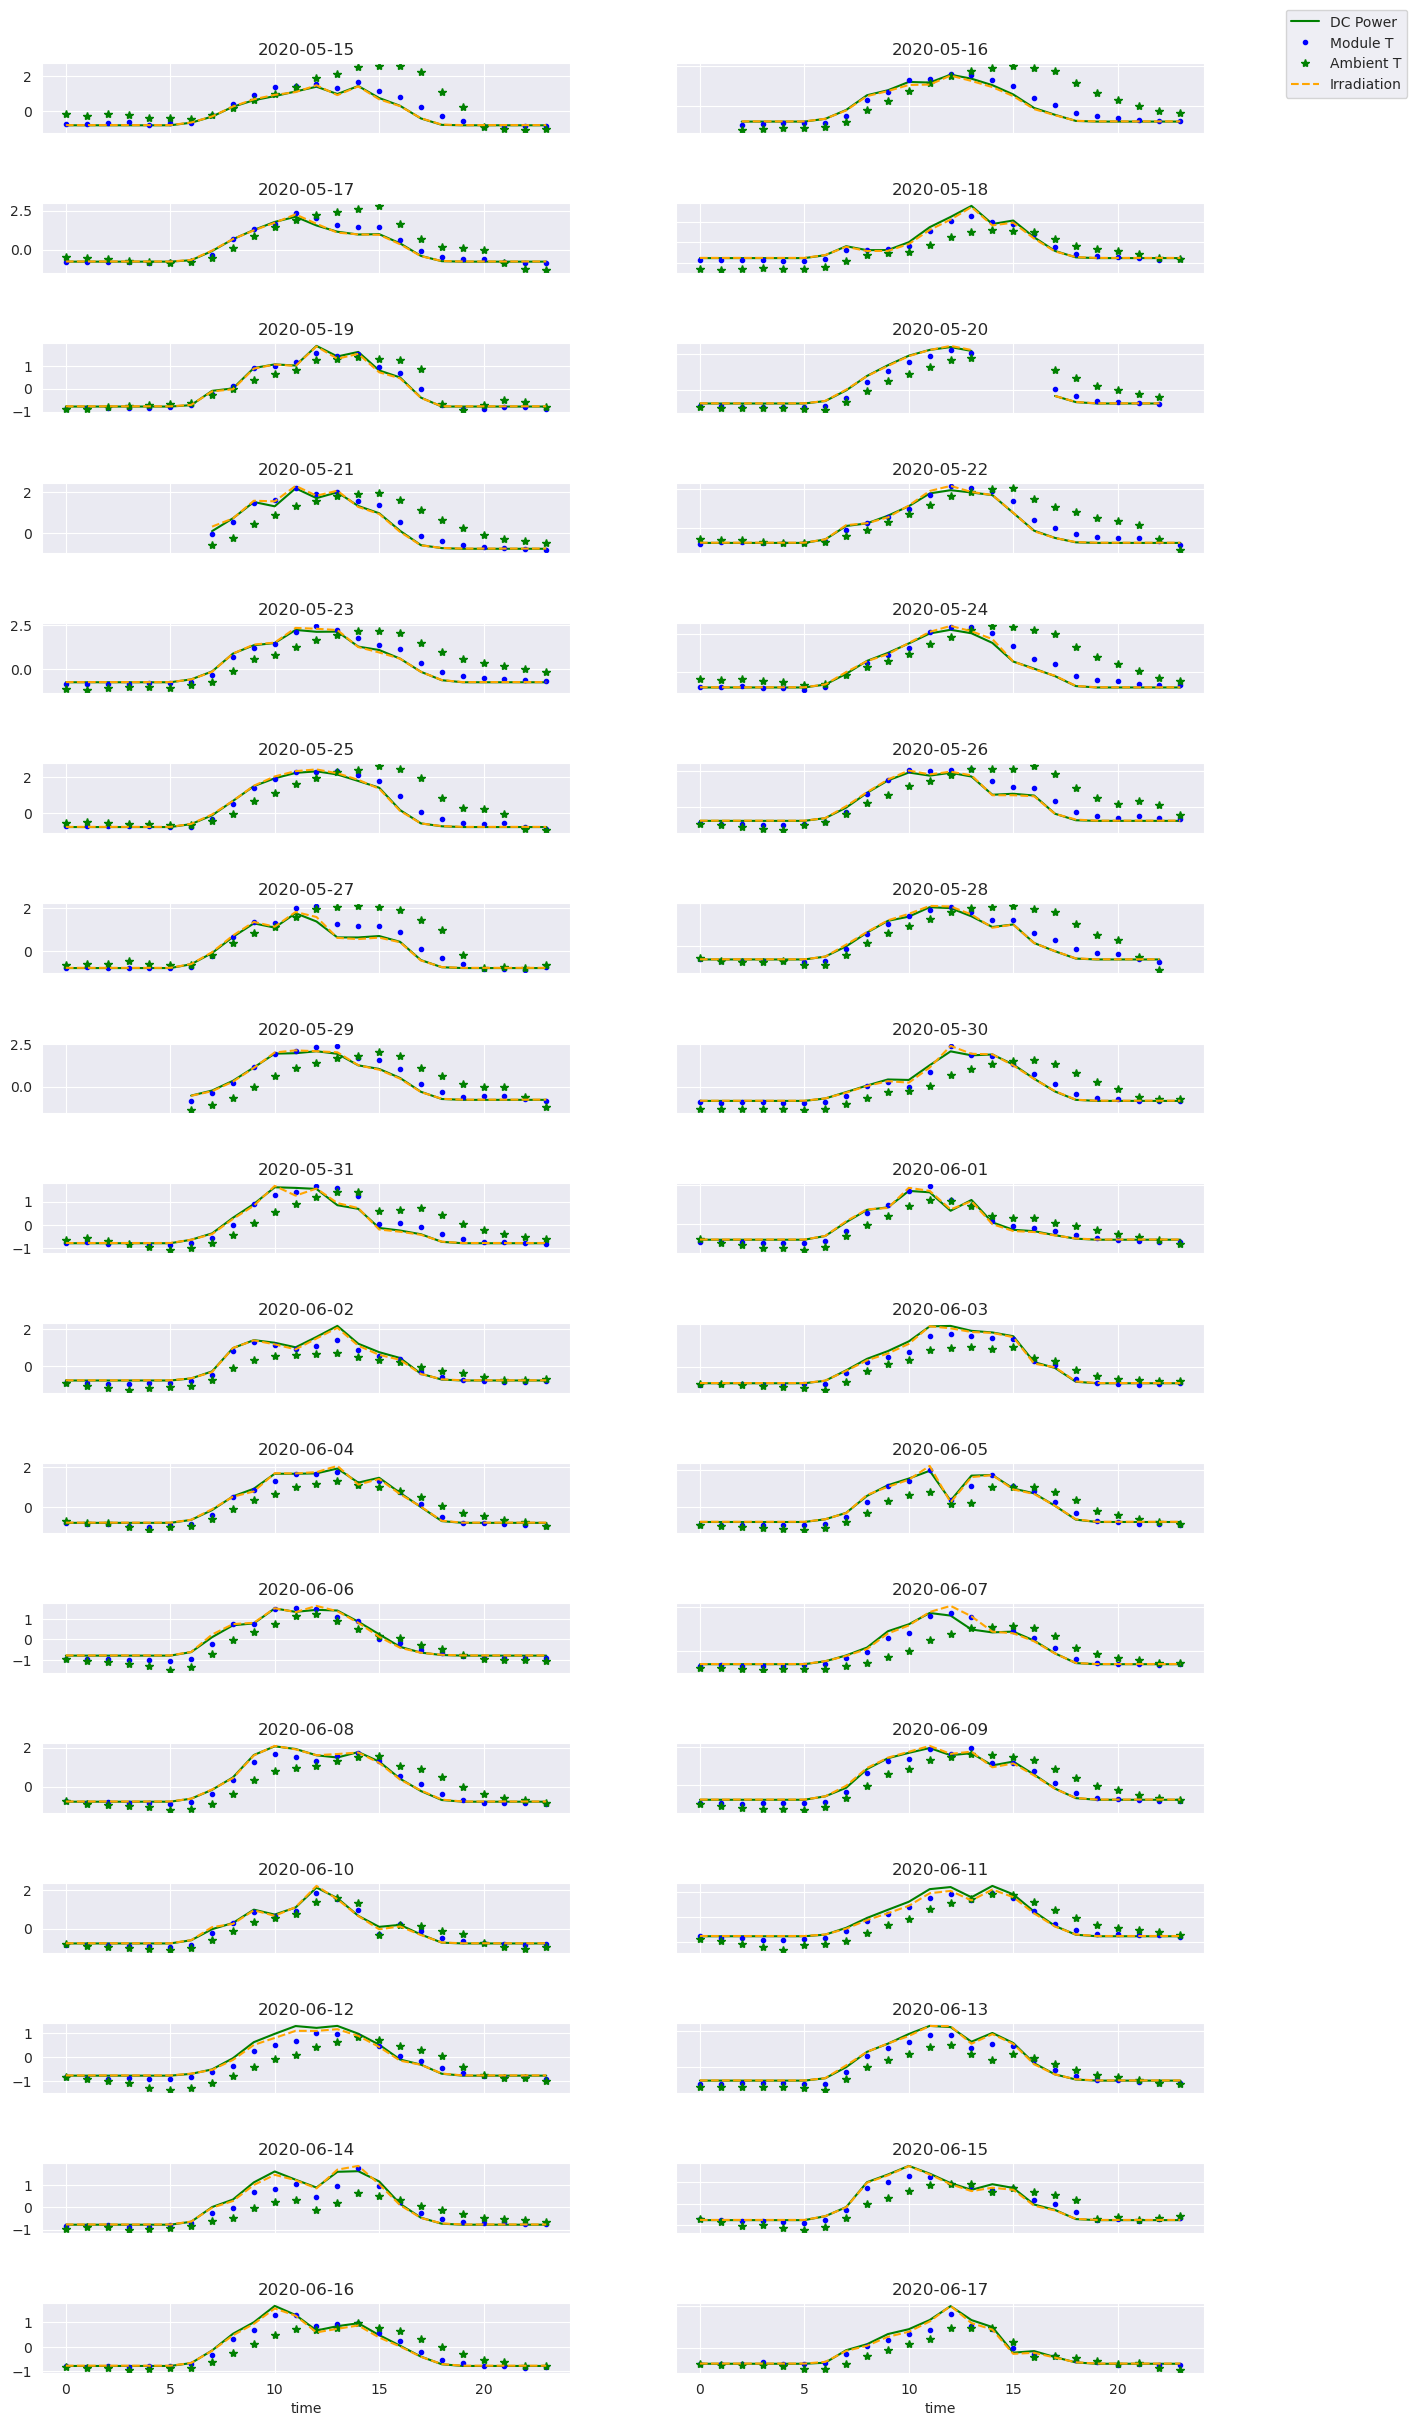

In [16]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
col_normalized=['DC_POWER','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE','IRRADIATION']
df=gen_sen[col_normalized]
scaler=StandardScaler()
df_normalized= pd.DataFrame(scaler.fit_transform(df), columns=col_normalized).assign(time=gen_sen.time,Day=gen_sen.Day)

days=df_normalized.Day.unique()
cols1=df_normalized.groupby(['time','Day'])['DC_POWER'].mean().unstack()
cols2=df_normalized.groupby(['time','Day'])['MODULE_TEMPERATURE'].mean().unstack()
cols3=df_normalized.groupby(['time','Day'])['AMBIENT_TEMPERATURE'].mean().unstack()
cols4=df_normalized.groupby(['time','Day'])['IRRADIATION'].mean().unstack()

f, ax = plt.subplots(17, 2, figsize=(15, 30), sharex=True)
f.subplots_adjust(hspace=1)

i = 0
handles,labels=[],[]

for a in range(0, 17):
    for b in range(0, 2):
        ax1 = ax[a, b]
        cols1.plot(sharex=True,sharey=True, y=cols1.columns[i], color='green', ax=ax1, legend=False, label='DC POWER')
        cols2.plot(sharex=True,sharey=True, y=cols2.columns[i], style='b.', ax=ax1, legend=False, label='Module T')
        cols3.plot(sharex=True,sharey=True, y=cols3.columns[i], style='g*', ax=ax1, legend=False, label='Ambient T')
        cols4.plot(sharex=True,sharey=True, y=cols4.columns[i], style='--',color='orange', ax=ax1, legend=False, label='Irradiation')
        ax1.set_title(days[i])
        ax1.set_xlabel('time')
        ax1.set_ylabel('')
        ax1.label_outer()
        i += 1
        
handles, labels=[ax1.lines[0],ax1.lines[1],ax1.lines[2],ax1.lines[3]],['DC Power','Module T','Ambient T','Irradiation']
f.legend(handles,labels,bbox_to_anchor=(1.04,0.90))


<font size='+1'> 
The figures above demonstrate that:

* The pattern of DC power and module temperature closely aligning with irradiation indicates that there were no failur in the solar panels level. However, looking at the DC power generated by all the panels and comparing it with irradiation pattern (as shown in the figures below), it becomes evident that some panels experienced failures on June 7th and June 14th. Although no other days showed any inverter failures, some inverters performed below the expected level (for example on May 27th, May 31st and June 6th). Shade and dirt accumulation are among the common factors that can lead to panel failure or underperformance.
 
* In instances where there is no power data available, there is also no temperature data. For example, during the afternoon of May 7th, 2020. This indicates that there may have been a plant shutdown during those intervals. To elaborate this assumption further, we are going to verify the integrity of the time stamp for any gaps
    


</font>

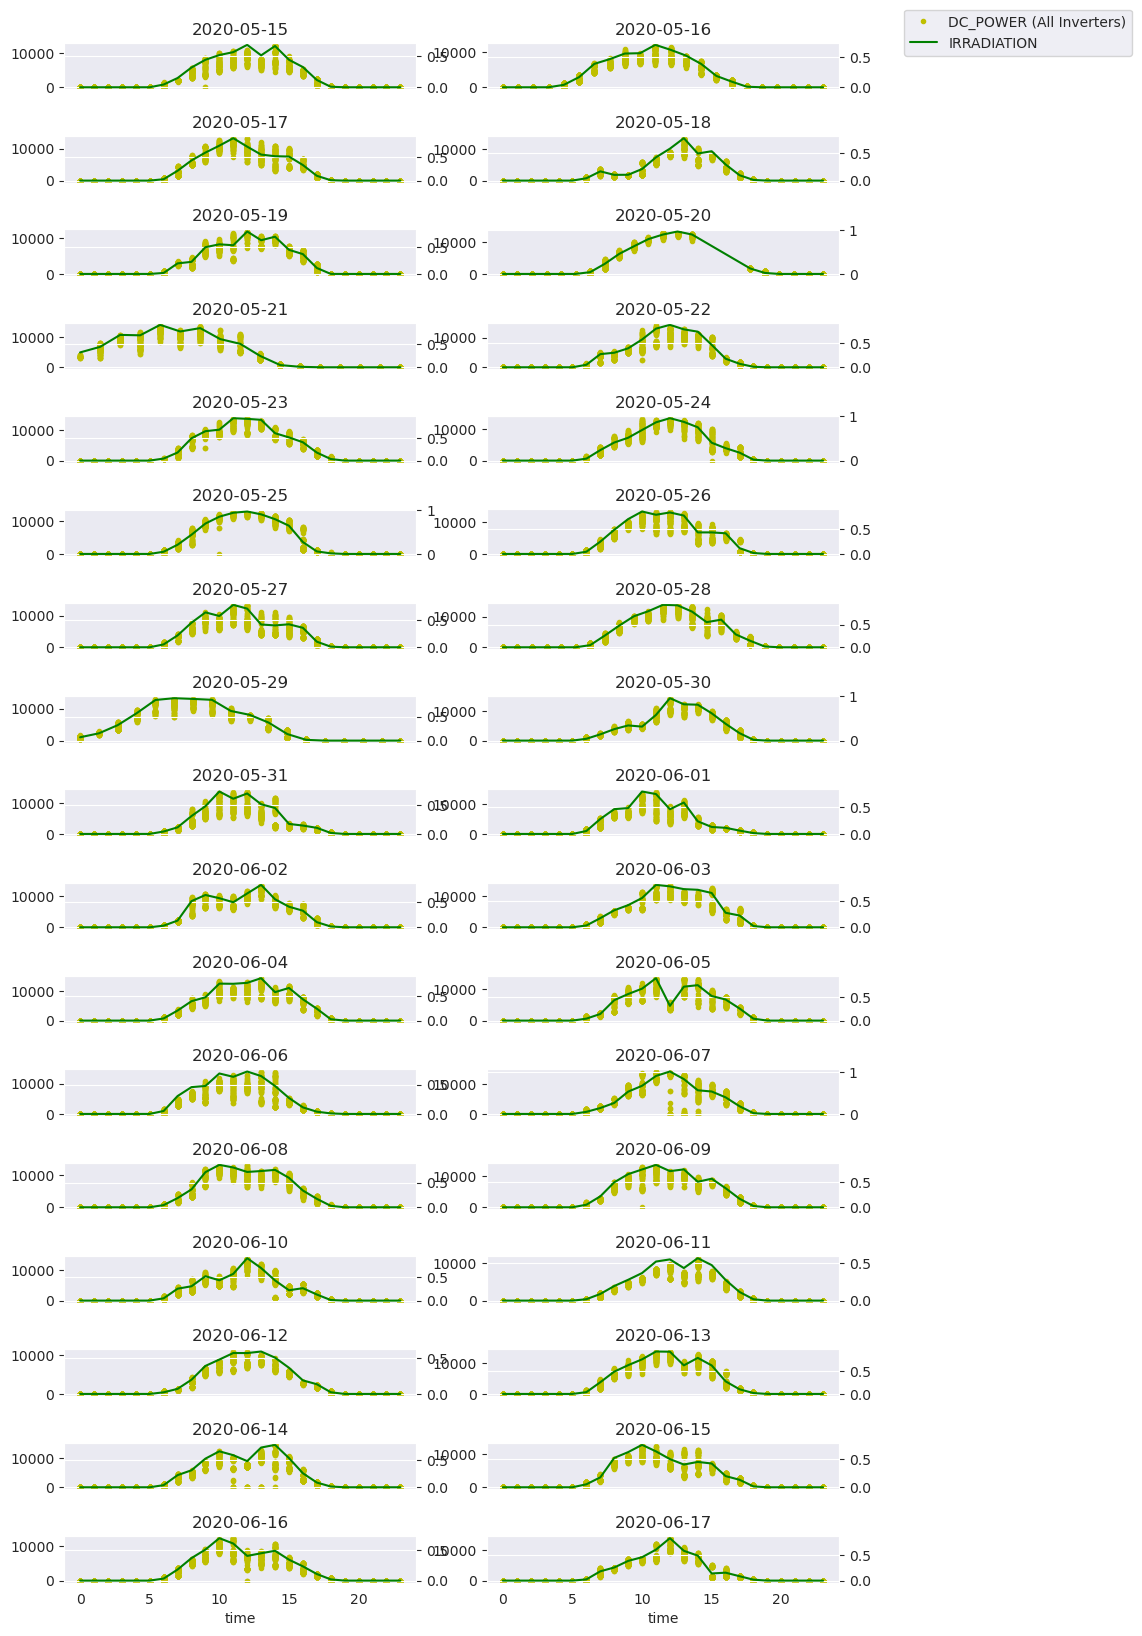

In [17]:
days=gen_sen.Day.unique()
f,ax=plt.subplots(17,2,figsize=(10,20))
f.subplots_adjust(hspace=1)
i=0
for a in range(0,17):
    for b in range(0,2):
        ax1=ax[a,b]
        gen_sen[gen_sen.Day==days[i]].plot(sharex=True,x='time',y='DC_POWER',style='y.',ax=ax1,legend=False)
        gen_sen[gen_sen.Day==days[i]].groupby('time').mean().plot(sharex=True,y='IRRADIATION',color='green',ax=ax1,legend=False,secondary_y=True)
        ax1.set_title(days[i])
        i+=1


handles, labels=[ax1.lines[0],ax1.right_ax.lines[0]],['DC_POWER (All Inverters)','IRRADIATION']
f.legend(handles,labels,bbox_to_anchor=(1.2,0.90))

<font size='+1'> 

June 7th and June 14th are suspicious for failur of some solar panels. May 27th, May 31st and June 6th .Let's look closer into the inverters performance for these days. 

</font>

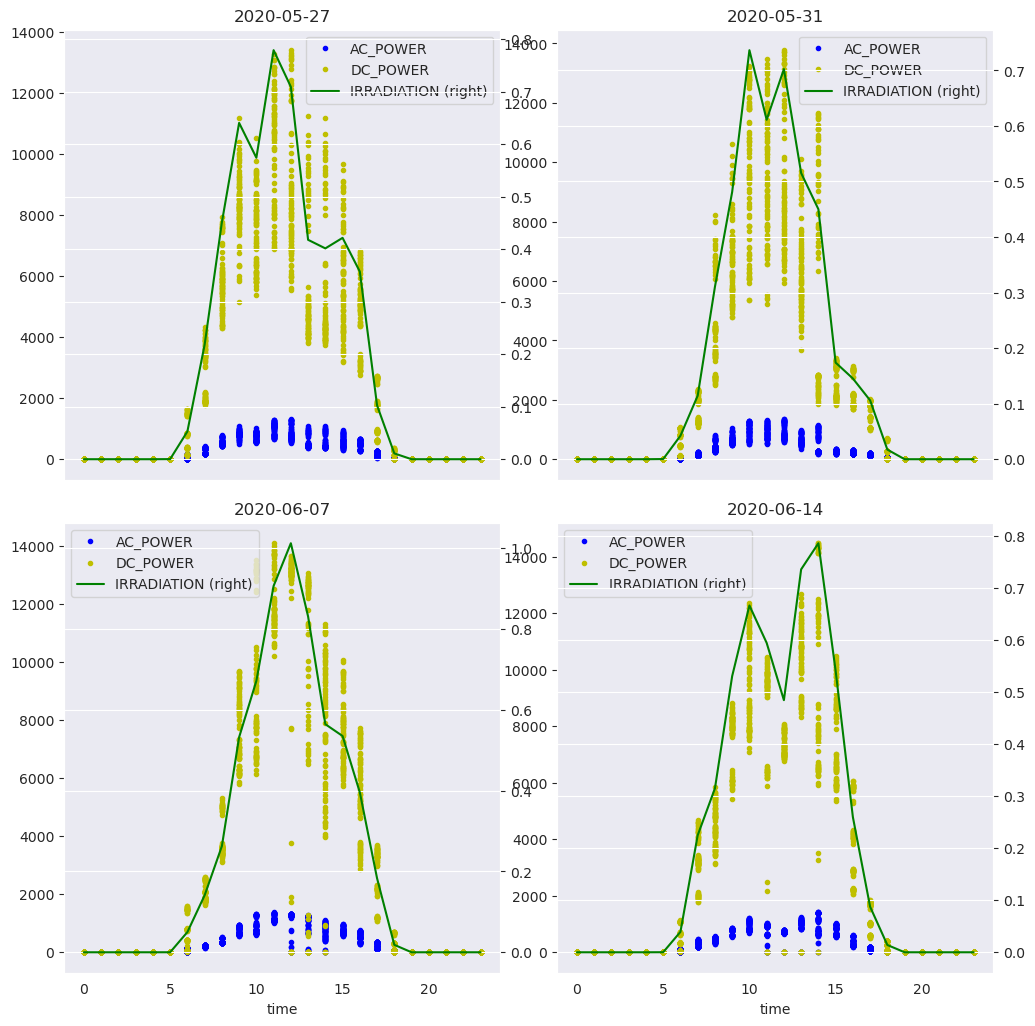

In [18]:
days=['2020-05-27','2020-05-31','2020-06-07','2020-06-14']
f,ax=plt.subplots(2,2,figsize=(10,10))
plt.tight_layout(pad=1)
i=0
for a in range(0,2):
    for b in range(0,2):
        ax1=ax[a,b]
        gen_sen[gen_sen.Day.astype(str)==days[i]].plot(sharex=True,x='time',y='AC_POWER',style='b.',ax=ax1)
        gen_sen[gen_sen.Day.astype(str)==days[i]].plot(sharex=True,x='time',y='DC_POWER',style='y.',ax=ax1)
        gen_sen[gen_sen.Day.astype(str)==days[i]].groupby('time').mean().plot(sharex=True,y='IRRADIATION',color='green',ax=ax1,secondary_y=True)
        ax1.set_title(days[i])
        i+=1


### Cheking for gaps in the timestamp

In [19]:
gen_sen['Time_Gap']=gen_sen.DATE_TIME.diff()/ pd.Timedelta(minutes=1)
df_gap=gen_sen[(gen_sen['Time_Gap']!=0) & (gen_sen['Time_Gap']!=15)]
time_gap_start=gen_sen.loc[df_gap.index[1:]-1,'DATE_TIME'].tolist()
time_gap_end=gen_sen.loc[df_gap.index[1:],'DATE_TIME'].tolist()

duration=gen_sen.loc[df_gap.index,'Time_Gap'].tolist()[1:]
total_minutes=gen_sen[(gen_sen['Time_Gap']!=0) & (gen_sen['Time_Gap']!=15)].Time_Gap.sum()

print('Data is missing for the following intervals: \n')
from prettytable import PrettyTable
table = PrettyTable()
table.add_column("Start time", time_gap_start)
table.add_column("End time", time_gap_end)
table.add_column("Duration (minutes)", duration)

print(table)


Data is missing for the following intervals: 

+---------------------+---------------------+--------------------+
|      Start time     |       End time      | Duration (minutes) |
+---------------------+---------------------+--------------------+
| 2020-05-15 23:00:00 | 2020-05-16 02:00:00 |       180.0        |
| 2020-05-19 11:30:00 | 2020-05-19 12:30:00 |        60.0        |
| 2020-05-20 13:15:00 | 2020-05-20 17:30:00 |       255.0        |
| 2020-05-20 22:45:00 | 2020-05-21 07:45:00 |       540.0        |
| 2020-05-23 05:00:00 | 2020-05-23 06:45:00 |       105.0        |
| 2020-05-23 21:30:00 | 2020-05-23 22:00:00 |        30.0        |
| 2020-05-25 05:30:00 | 2020-05-25 06:00:00 |        30.0        |
| 2020-05-28 22:15:00 | 2020-05-29 06:15:00 |       480.0        |
| 2020-06-17 06:00:00 | 2020-06-17 06:45:00 |        45.0        |
+---------------------+---------------------+--------------------+
